In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
diffusion="0.05percent"
# diffusion="0.0percent"
# file_id = "1"
# file_id = "2954"
file_id = "2638"

hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt_{diffusion}_smear_{file_id}.h5", "MC/hits")

# hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+3000


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_5.0percent_smear_3273_1.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,event_id,x,y,z,energy
0,321959,-437.957336,-1230.252808,2009.536743,0.000025
1,321959,-383.094147,-1209.948853,2020.749634,0.000050
2,321959,-433.576904,-1134.386108,2024.267090,0.000025
3,321959,-390.726898,-1167.759033,2024.357788,0.000074
4,321959,-370.979614,-1134.344482,2024.456421,0.000025
...,...,...,...,...,...
372508,322032,1487.139893,-1582.079834,533.749512,0.000050
372509,322032,1469.414795,-1566.684570,534.221497,0.000422
372510,322032,1470.067749,-1534.052002,534.249146,0.001017
372511,322032,1507.128174,-1568.410034,534.292114,0.000050


[321959 321960 321961 321962 321963 321965 321966 321967 321968 321969
 321970 321971 321972 321973 321974 321976 321977 321978 321979 321980
 321981 321982 321983 321984 321985 321986 321987 321988 321989 321990
 321991 321992 321993 321994 321995 321996 321997 321998 321999 322000
 322001 322002 322003 322004 322005 322006 322007 322008 322009 322011
 322012 322013 322015 322016 322017 322018 322019 322020 322022 322023
 322024 322025 322026 322027 322028 322029 322030 322032]


In [2]:
eid=320000
eid=event_list[6]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

,event_id,x,y,z,energy
6015,321966,-801.711792,1933.251221,5235.251465,0.003100
6016,321966,-798.705139,1936.351685,5235.289062,0.000198
6017,321966,-797.043152,1937.121460,5235.886719,0.002827
6018,321966,-802.209961,1930.361694,5236.758789,0.000942
6019,321966,-792.793640,1938.703003,5237.208984,0.000694
...,...,...,...,...,...
6990,321966,-460.771484,1679.420898,5728.872559,0.002951
6991,321966,-463.534332,1666.067871,5729.037109,0.000124
6992,321966,-461.194244,1674.219482,5729.176758,0.001190
6993,321966,-469.504211,1651.989380,5729.218262,0.000546


In [3]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
# energy_threshold=0
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)

# energy_threshold = 0.0004

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))


# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

Diffussion smear is:  2.0 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  3
Radius scale factor is:  7
Hit grouping factor is:  3
Tortuosity distance scale is: 175.0


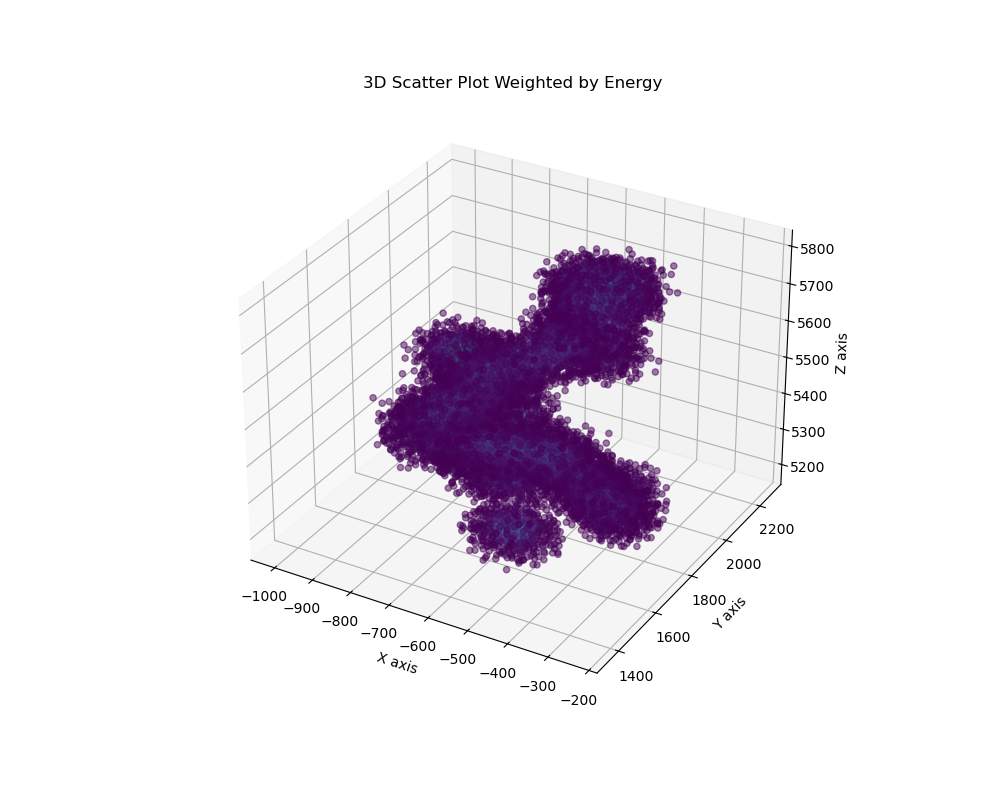

In [4]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [5]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(data)

,event_id,x,y,z,energy
0,321966,-1007.289856,1957.896973,5451.047363,0.000025
1,321966,-992.348877,1991.343140,5473.524414,0.000025
2,321966,-984.138428,1919.269409,5438.103027,0.000025
3,321966,-981.687805,1969.407959,5462.893066,0.000025
4,321966,-979.737549,1895.976074,5405.874023,0.000025
...,...,...,...,...,...
9183,321966,-252.170181,1692.171875,5333.928711,0.000025
9184,321966,-250.544449,1771.683838,5277.816895,0.000025
9185,321966,-245.274033,1713.054932,5270.596680,0.000025
9186,321966,-243.959488,1718.368042,5313.998535,0.000025


Mean z: 5469.335  diffusion =  140
Mean Sigma:  140
Print


,x,y,z,energy,group_id
0,-851.255371,1988.908691,5439.810547,0.466923,0
1,-788.621216,1927.950684,5262.465332,0.203855,0
2,-772.482300,2028.426392,5380.991211,0.222380,0
3,-732.173706,1810.458008,5279.453125,0.072132,0
4,-732.173584,1949.975586,5319.830566,0.009547,0
5,-709.302368,1567.699585,5499.043945,0.103954,0
6,-711.257080,1970.290283,5301.273438,0.009888,0
7,-631.331177,1549.257446,5599.681152,0.073420,0
8,-610.386963,1828.284058,5320.576172,0.094673,0
9,-589.676819,1611.073242,5459.854492,0.083194,0


23 2.4503887612372637


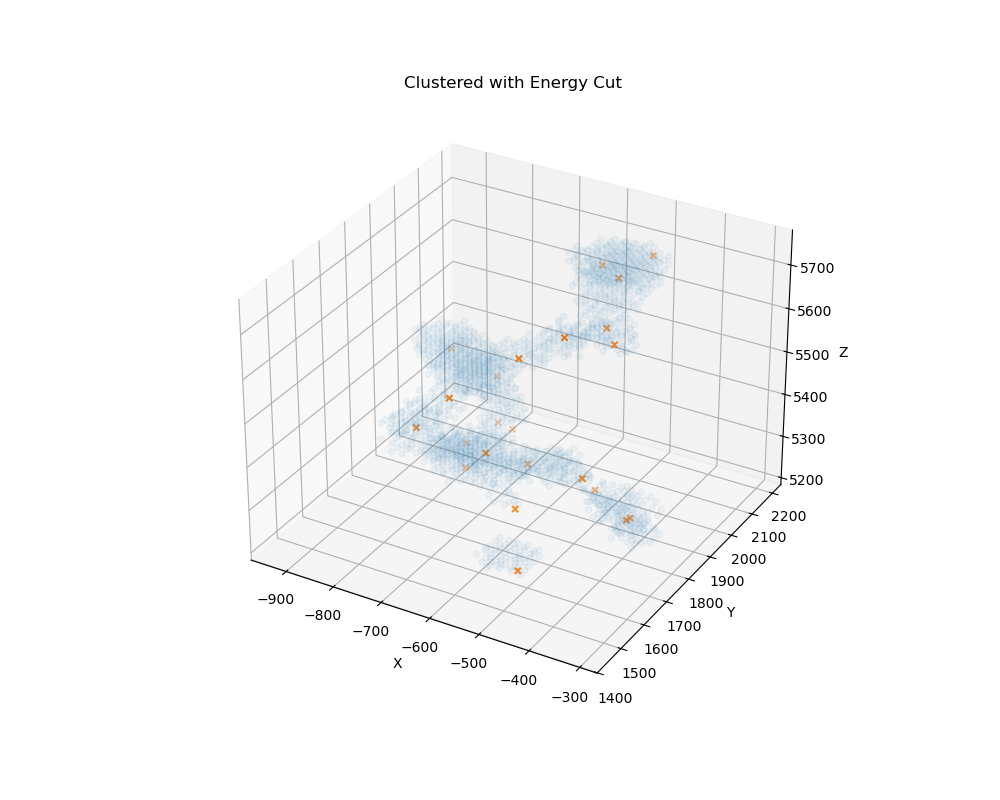

In [6]:

# display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)


# Apply grouping
data_copy = data.copy()

df_merged = CutandRedistibuteEnergy(data_copy, energy_threshold)

mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())
df_merged = GroupHits(df_merged, mean_sigma_group)

# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

print("Print")
display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Unclustered
# for gid in sorted(df_merged.group_id.unique()):
#     # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
#     # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
#     temp_df = df_merged[df_merged.group_id == gid]
#     ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

# Clustered
for gid in sorted(node_centers_df.group_id.unique()):
    ax.scatter(df_merged['x'], df_merged['y'], df_merged['z'], marker='o',alpha=0.05)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = node_centers_df[node_centers_df.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Clustered with Energy Cut')
plt.show()



In [7]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,321966.0,-900.0,2040.0,5460.0,-851.255371,1988.908691,5439.810547,0.466923,0
1,321966.0,-760.0,1900.0,5320.0,-760.397400,1938.963135,5291.147949,0.213402,0
2,321966.0,-760.0,2040.0,5320.0,-741.869690,1999.358337,5341.132324,0.232268,0
3,321966.0,-760.0,1760.0,5320.0,-732.173706,1810.458008,5279.453125,0.072132,0
4,321966.0,-760.0,1620.0,5460.0,-709.302368,1567.699585,5499.043945,0.103954,0
5,321966.0,-620.0,1480.0,5600.0,-631.331177,1549.257446,5599.681152,0.073420,0
6,321966.0,-620.0,1760.0,5320.0,-610.386963,1828.284058,5320.576172,0.094673,0
7,321966.0,-620.0,1620.0,5460.0,-589.676819,1611.073242,5459.854492,0.083194,0
8,321966.0,-620.0,2040.0,5600.0,-589.653442,2109.206787,5661.652344,0.228139,0
9,321966.0,-480.0,1620.0,5740.0,-501.064407,1659.007507,5700.965088,0.138277,0


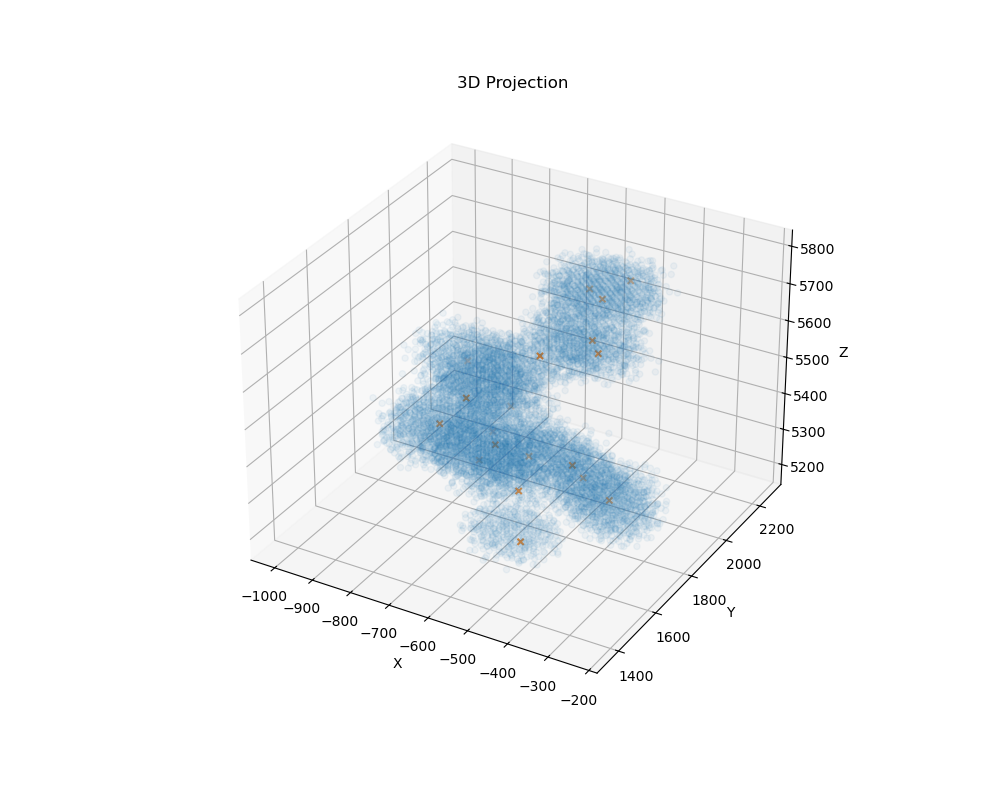

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

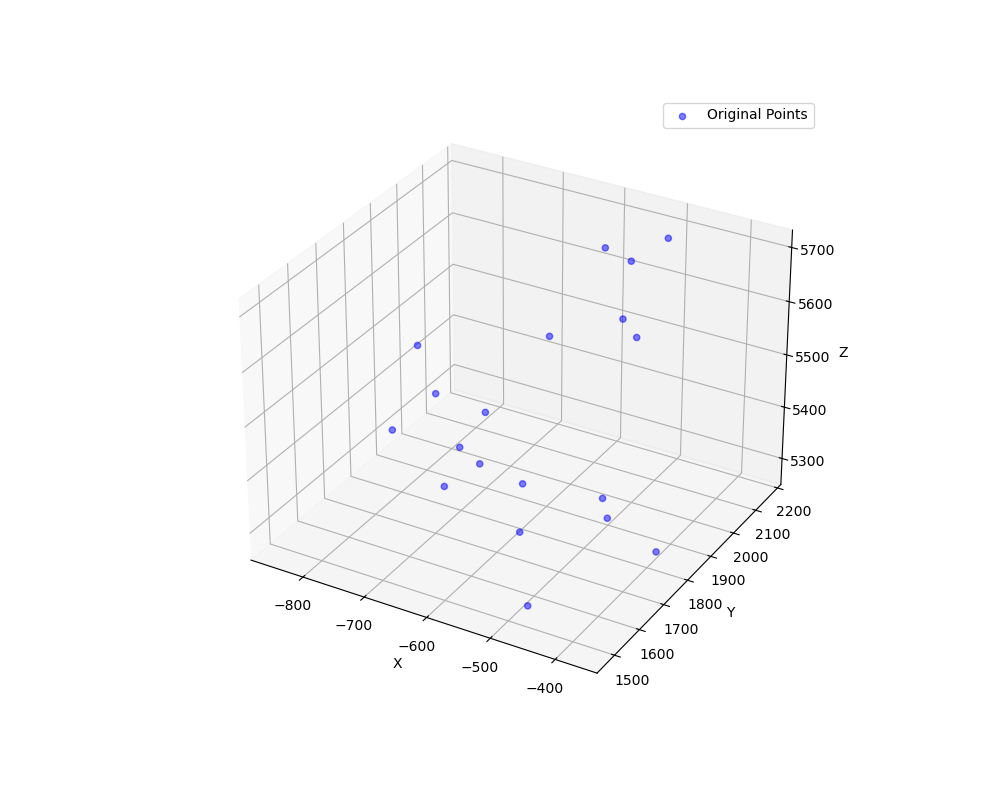

In [9]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Original Points', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [10]:
display(databin)

databin.to_hdf("../data/test/test.h5", "MC/hits")

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,321966.0,-900.0,2040.0,5460.0,-851.255371,1988.908691,5439.810547,0.466923,0
1,321966.0,-760.0,1900.0,5320.0,-760.397400,1938.963135,5291.147949,0.213402,0
2,321966.0,-760.0,2040.0,5320.0,-741.869690,1999.358337,5341.132324,0.232268,0
3,321966.0,-760.0,1760.0,5320.0,-732.173706,1810.458008,5279.453125,0.072132,0
4,321966.0,-760.0,1620.0,5460.0,-709.302368,1567.699585,5499.043945,0.103954,0
5,321966.0,-620.0,1480.0,5600.0,-631.331177,1549.257446,5599.681152,0.073420,0
6,321966.0,-620.0,1760.0,5320.0,-610.386963,1828.284058,5320.576172,0.094673,0
7,321966.0,-620.0,1620.0,5460.0,-589.676819,1611.073242,5459.854492,0.083194,0
8,321966.0,-620.0,2040.0,5600.0,-589.653442,2109.206787,5661.652344,0.228139,0
9,321966.0,-480.0,1620.0,5740.0,-501.064407,1659.007507,5700.965088,0.138277,0


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_52852/1135446823.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  databin.to_hdf("../data/test/test.h5", "MC/hits")


Diffussion smear is:  2.0 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  3
Radius scale factor is:  7
Hit grouping factor is:  3
Tortuosity distance scale is: 175.0
Median distance to the closest row: 128.6369566149379
Distances to iterate over [  1  65 129 193 257 322 386 450 514 579 643 707 771 836 900]
Dist Thresh 530.972
Pass Flag: True
The primary track is:  0
    event_id           x            y            z    energy  group_id  id  \
0   321966.0 -851.255371  1988.908691  5439.810547  0.466923         0   0   
1   321966.0 -741.869690  1999.358337  5341.132324  0.232268         0   2   
2   321966.0 -760.397400  1938.963135  5291.147949  0.213402         0   1   
3   321966.0 -732.173706  1810.458008  5279.453125  0.072132         0   3   
4   321966.0 -610.386963  1828.284058  5320.576172  0.094673         0   6   
5   321966.0 -489.436279  1868.993774  5279.825195  0.044173         0  13   
6   321966.0 -371.486313  1758.971680  5308.590576  0.117782   

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
0,321966.0,-851.255371,1988.908691,5439.810547,0.466923,0,0,1,0,0.000000,0.000000,1.000000,8.504902e-18
2,321966.0,-741.869690,1999.358337,5341.132324,0.232268,0,2,1,0,147.688232,103.053090,1.259304,4.333729e-01
1,321966.0,-760.397400,1938.963135,5291.147949,0.213402,0,1,1,0,228.244388,78.977909,1.068818,2.365079e-01
3,321966.0,-732.173706,1810.458008,5279.453125,0.072132,0,3,1,0,360.331153,42.676615,1.387481,6.410574e-01
6,321966.0,-610.386963,1828.284058,5320.576172,0.094673,0,6,1,0,490.103584,87.774603,1.056240,2.266518e-01
13,321966.0,-489.436279,1868.993774,5279.825195,0.044173,0,13,1,0,624.069964,37.567523,1.195825,4.302911e-01
18,321966.0,-371.486313,1758.971680,5308.590576,0.117782,0,18,1,0,787.912886,66.890458,1.000000,0.000000e+00
17,321966.0,-414.544128,1649.675659,5441.958008,0.057395,0,17,1,0,965.638707,68.266166,1.000000,0.000000e+00
15,321966.0,-462.206787,1481.262329,5300.852539,0.007615,0,15,1,0,1190.462042,87.647273,1.000000,9.650618e-17


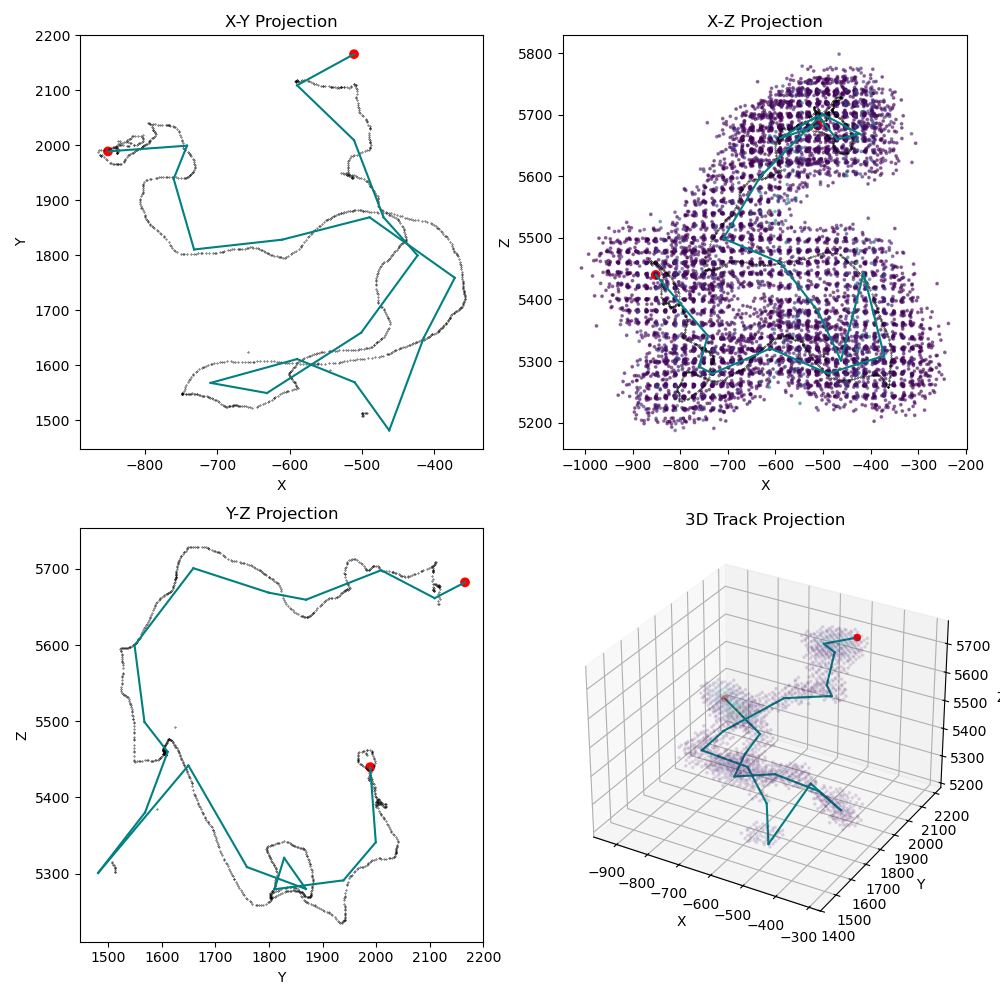

In [11]:
# Apply the tracking reconstruction

# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy", "group_id"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
# ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
ax_3D.scatter(df_merged.x, df_merged.y, df_merged.z, c=df_merged.energy, marker='o', alpha=0.1,s=3)


plt.tight_layout()
plt.show()

In [12]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,321966.0,0,1,0,10,2529.357,2.450389,1.079397,0.619558,0.699191,0.531099,1.129652,1.236011,0.216686,0.331159,Primary


Text(0, 0.5, 'Angle')

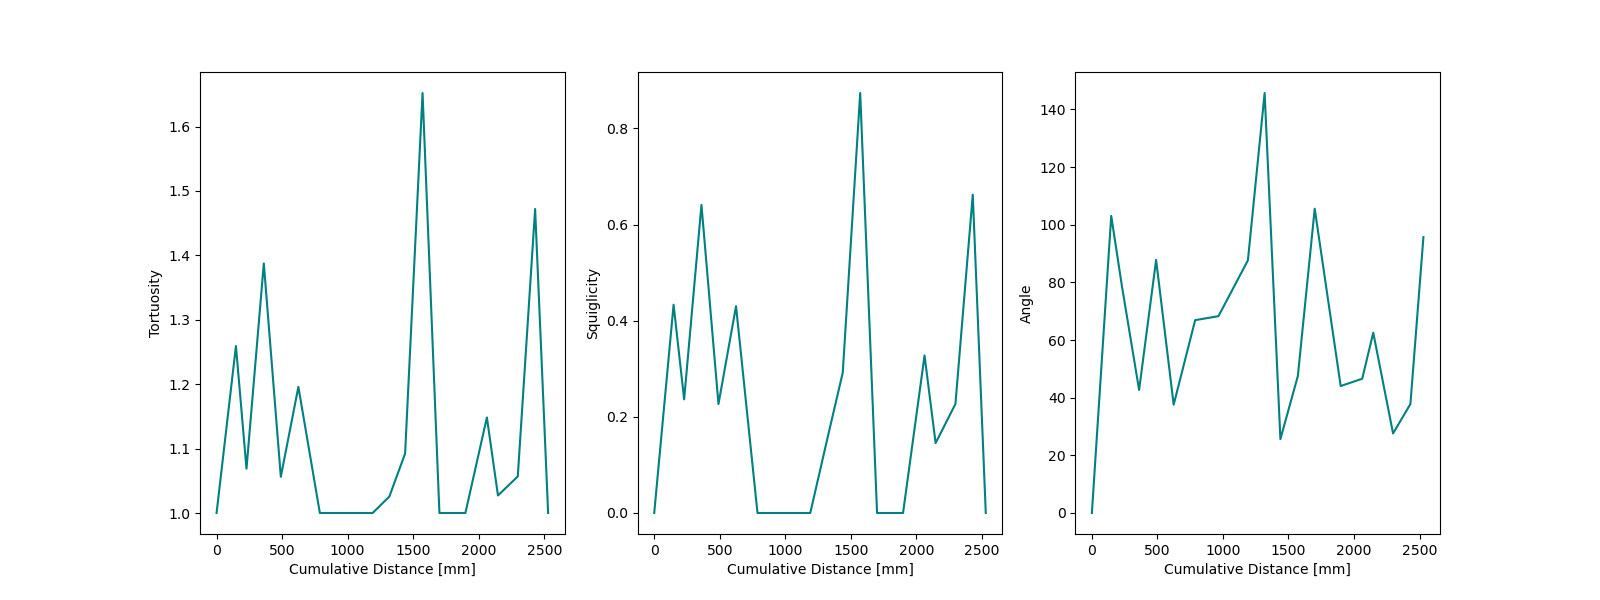

In [13]:

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Tortuosity"], c="Teal")
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Squiglicity"], c="Teal")
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["angle"], c="Teal")
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("Angle")